# Gradient Vanishing Analysis in RESNET50 without skip connections

### Motivation

Moving on from `VGG19` and `VGG38` network we wish to explore more deeper network in `RESNET50` and see how the nuances in this architecture changes gradient behavior.

### Approach

Before training the RESNET50 in its original form, we slightly modify the architecture by taking the skip connections out.

The reason we do this is because we understand that skip connections play a big role in tackling the vanishing gradients issue and also allow us to train deeper network.

#### Layers tracked:
- `conv1`: Early convolutional layer
- `layer1.0.conv1`: Mid-level convolutional layer
- `layer2.0.conv2`: Mid-level convolutional layer
- `layer3.5.conv3`: Deep convolutional layer
- `fc`: First fully connected layer

**Import libraries**

In [9]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from collections import defaultdict
from scipy.stats import gaussian_kde
from matplotlib.animation import FuncAnimation

**Load RESNET50 model without skip connections**

In [2]:
class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_planes, planes, stride=1, skip=False):
        super(Bottleneck, self).__init__()
        self.skip = skip
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.conv3 = nn.Conv2d(planes, self.expansion * planes, kernel_size=1, bias=False)
        self.relu = nn.ReLU(inplace=False)
        self.downsample = None
        if stride != 1 or in_planes != self.expansion * planes:
            self.downsample = nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False)

    def forward(self, x):
        identity = x
        out = self.relu(self.conv1(x))
        out = self.relu(self.conv2(out))
        out = self.conv3(out)
        if self.skip:
            if self.downsample is not None:
                identity = self.downsample(identity)
            out = out + identity
        return self.relu(out)

class CustomResNet50(nn.Module):
    def __init__(self, skip=False):
        super(CustomResNet50, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(64, 3, skip)
        self.layer2 = self._make_layer(128, 4, skip, stride=2)
        self.layer3 = self._make_layer(256, 6, skip, stride=2)
        self.layer4 = self._make_layer(512, 3, skip, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * Bottleneck.expansion, 10)

    def _make_layer(self, planes, blocks, skip, stride=1):
        layers = [Bottleneck(self.in_planes, planes, stride, skip)]
        self.in_planes = planes * Bottleneck.expansion
        for _ in range(1, blocks):
            layers.append(Bottleneck(self.in_planes, planes, skip=skip))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x).view(x.size(0), -1)
        x = self.fc(x)
        return x

model = CustomResNet50(skip=False).cuda()

**Verify no. of trainable parameters**

In [3]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params:,}")

Trainable parameters: 23,475,402


**Register backward hook to log gradients**

In [4]:
selected_layers = ["conv1", "layer1.0.conv1", "layer2.0.conv2", "layer3.5.conv3", "fc"]
gradients = {}

def register_hooks(model):
    for name, module in model.named_modules():
        if name in selected_layers and (isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear)):
            gradients[name] = []
            def hook(module, grad_input, grad_output, name=name):
                gradients[name].append(grad_output[0].norm().item())
            module.register_full_backward_hook(hook)

register_hooks(model)

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
train_data = datasets.CIFAR10(root='../data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)

epoch_gradients = defaultdict(list)

**Define loss and optimizer**

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

**Train the model**

In [7]:
def train(model, epochs=1):
    model.train()
    for epoch in tqdm(range(epochs)):
        # Temporary storage for one epoch
        batch_grads = defaultdict(list)

        for inputs, labels in train_loader:
            inputs, labels = inputs.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
            # After backward, batch-level gradients are in global `gradients`
            for layer in selected_layers:
                if gradients[layer]:
                    batch_grads[layer].extend(gradients[layer])
                    gradients[layer].clear()  # Clear for next batch

        # Sample 20 values (or pad with zeros if less) for this epoch
        for layer in selected_layers:
            layer_grads = batch_grads[layer]
            if len(layer_grads) >= 20:
                sampled = np.random.choice(layer_grads, 20, replace=False)
            else:
                sampled = np.pad(layer_grads, (0, 20 - len(layer_grads)), constant_values=0)
            epoch_gradients[layer].append(sampled.tolist())

        print(f"Epoch {epoch+1} complete")


In [8]:
train(model, epochs=10)

 10%|█         | 1/10 [00:58<08:47, 58.63s/it]

Epoch 1 complete


 20%|██        | 2/10 [01:56<07:47, 58.48s/it]

Epoch 2 complete


 30%|███       | 3/10 [02:55<06:50, 58.61s/it]

Epoch 3 complete


 40%|████      | 4/10 [03:54<05:51, 58.58s/it]

Epoch 4 complete


 50%|█████     | 5/10 [04:52<04:52, 58.51s/it]

Epoch 5 complete


 60%|██████    | 6/10 [05:50<03:53, 58.43s/it]

Epoch 6 complete


 70%|███████   | 7/10 [06:49<02:55, 58.40s/it]

Epoch 7 complete


 80%|████████  | 8/10 [07:47<01:56, 58.37s/it]

Epoch 8 complete


 90%|█████████ | 9/10 [08:46<00:58, 58.65s/it]

Epoch 9 complete


100%|██████████| 10/10 [09:45<00:00, 58.55s/it]

Epoch 10 complete


In [11]:

layers = ['conv1', 'layer1.0.conv1', 'layer2.0.conv2', 'layer3.5.conv3', 'fc']

In [12]:
def create_log_hist_animation_matplotlib(epoch_gradients, layers, num_epochs=10, save_path='log_hist_gradients.gif'):
    fig, ax = plt.subplots(figsize=(8, 6))

    # Log-spaced bins from 1e-10 to 1e0 (1)
    log_bins = np.logspace(-10, 0, 50)

    def update(epoch):
        ax.clear()
        for layer in layers:
            data = epoch_gradients[layer][epoch]
            if len(data) > 1 and np.isfinite(data).all():
                log_data = np.abs(data) + 1e-10  # Avoid log(0)
                hist, bins = np.histogram(log_data, bins=log_bins, density=True)
                bin_centers = (bins[:-1] + bins[1:]) / 2
                ax.plot(bin_centers, hist, label=layer)

        ax.set_xscale('log')
        ax.set_xlim(1e-10, 1)
        ax.set_ylim(0, None)
        ax.set_title(f"Log-Scaled Gradient Histogram - Epoch {epoch + 1}")
        ax.set_xlabel("Gradient Magnitude (log scale)")
        ax.set_ylabel("Density")
        ax.legend()
        ax.grid(True, which="both", ls="--", linewidth=0.5)

    ani = FuncAnimation(fig, update, frames=num_epochs, repeat=False)
    ani.save(save_path, writer='pillow', fps=1)
    print(f"Saved animation to {save_path}")


Saved animation to log_hist_gradients_without_skip.gif


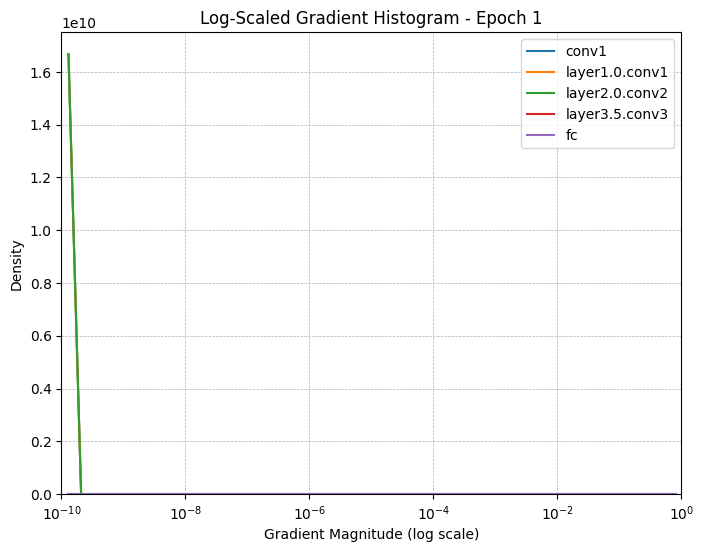

In [13]:
# Step 3: Run it
create_log_hist_animation_matplotlib(epoch_gradients, layers, num_epochs=10, save_path='log_hist_gradients_without_skip.gif')

**Observations**

- The graph shows how the distribution of gradient magnitudes (on a log scale) evolves across epochs for each layer.
- As we can see the for each of the considered layers, the gradient magnitude is close to 1e-10, which is very low and cannot contribute any further to weight updation.
- This does prove that the skip connections do play a vital role in how the gradient changes during training, and `vanishing gradients` behavior is clearly visible.
- Lets put the skip connection back and train the model again to observe the gradient behavior.